In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# a) Target occupancy v.s. KPP & gamma?

In [4]:
def findCriticalXPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2

GenParms = lambda nDenseKPP: GenParameters(
    numTargets=2, 
    KPN=np.array([30, 170, 1000]), 
    KPS=lambda KPN: 1258, 
    NP0=[2], KPP=np.logspace(1,9,9+8*nDenseKPP), 
    gamma=[50], kbPP_fixed=0.4,
)
parm_num = GenParms(0)

In [5]:
equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

sOcc_num_rev = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    sOcc_num_rev[iloc] = num.calc_occS_modelB(parm, equi_num_rev.iloc[iloc])

2025-05-01 13:05:46.906402
Number of cores used:  27/36
Finished parallel processing.


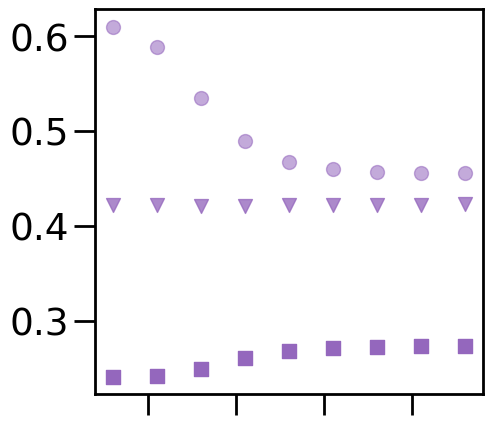

In [6]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[1.01,0.45], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$K_{eq}^{PN}[N]_{tot}$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
gam_color = 'tab:purple'
alphas = [5/9, 7/9, 1]
# alphas = [1/9, 3/9, 5/9, 7/9, 1]
markers = ['o','v','s', 'X', 'p']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_num['gamma'])
kpnList = np.unique(parm_num['KPN'])
CN0 = np.unique(parm_num['CN0'])
for i, kpn in enumerate(kpnList[::-1]):
    selected_num = ((parm_num['KPN']==kpn))
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num_rev / (parm_num['CP0']/parm_num['CS0']))[selected_num],
        marker=markers[i],  zorder=4, s=100,
        color = gam_color, alpha=alphas[i], 
        label='$10^{%.1f}$'%(np.log10(CN0*kpn)),
    )
            
ax.semilogx()
# plt.legend(**legend)
plt.xticks([1e-2, 1e0, 1e2, 1e4], ['', '', '', ''], **tickfont)
plt.yticks([0.3, 0.4, 0.5, 0.6], **tickfont)
plt.savefig('resT_vs_chiN_gamma_DIMER.png', transparent=True)

# b) residence time v.s. KPP & C0, dimer, model B¶

In [7]:
GenParms = lambda kbP, nDenseKPP :GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[2], area3Dto1D=[31], 
    KPP=np.logspace(1,9,8+7*nDenseKPP), kbPP_fixed=kbP   
)

parm_num = pd.concat([GenParms(0.05, 0), GenParms(0.25, 0), GenParms(1, 0)], axis=0)

In [8]:
def calc_resT_monomer_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+aS_to_aN) / koffN

resT_m_B_num = calc_resT_monomer_2state(parm_num)

equi_num_rev = numericSolver(parm_df=parm_num, labels=labelsSingleS, model=rxnSingleS)

resT_num_rev = np.zeros(parm_num.shape[0])
occ_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    resT_num_rev[iloc] = num.calc_resT_modelB(parm_num.iloc[iloc], equi_num_rev.iloc[iloc])
    occ_num[iloc] = num.calc_occS_modelB(parm_num.iloc[iloc], equi_num_rev.iloc[iloc])

2025-05-01 13:05:47.302372
Number of cores used:  24/36
Finished parallel processing.


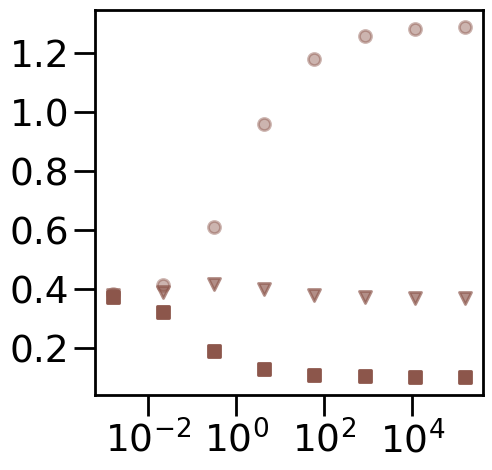

In [9]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.51], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [4/9, 6/9, 1]
markers = ['o','v','s']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kbList = np.unique(parm_num['kbPP'])
for i, kbP in enumerate(kbList):
    selected_num = parm_num['kbPP']==kbP
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (resT_num_rev/resT_m_B_num)[selected_num],
        lw=2, zorder=5, marker=markers[i], s=75,
        label='$10^{%.0f}$'%np.log10(kbP),
        color='tab:brown', alpha=alphas[i]
    )
ax.semilogx()
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()